In [1]:
from data_resources import fileToObjects as fetcher, transformObjects as transformer
from map_based_resources import point, mapResources

from PIL import Image
% matplotlib inline


## Experimental Testing for getting photo's out of multiple WMTS servers.
This Notebook experiments with a way  to get photo's as a datasource to later integrate it into the SailingRobots Website. 

To have the webmap tile services as an object we first get configuration from the json file. In this is the url of the webmap and the name etc. This variable is then initiated so that we can continue using it further the in the code and reduce unnecesary objects.

The static variables like the standardized rendering pixel size is also avalaible in the json and set globally.

In [2]:
configuration = fetcher.get_configuration()
standardized_rendering_pixel_size = configuration.standardized_rendering_pixel_size


## Calculate the position of the coordinate in WMTS
By using the Webmap tile matrix we can calculate the position of where the coordinate on the whole map. 

This is done by the following formula's:
$height = \frac{\text{matrix top left corner height}\;-\; longitude}{scale \;\times\; pixelsize \;\times\; \text{length of matrix}}
$ and  $width = \frac{lattitude \;-\; \text{matrix top left corner width}}{scale \;\times\; pixelsize \;\times\;\text{width of matrix}}$

The result is decimal number and the rows and columns are only whole numbers. the integer part of the results are used for the columns and the fractional parts are used to calculate the position on the image itself. the formula for that is $position = image size \;\times\; \text{fractional parts of height or width}$

In [3]:
def calculated_width(coordinates, matrix):
    return (coordinates[0] - matrix.topleftcorner[0]) / (
                matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator)


def calculated_height(coordinates, matrix):
    return (matrix.topleftcorner[1] - coordinates[1]) / (
                matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator)


def position_in_image(matrix_tile_size, value_part):
    return matrix_tile_size * value_part


## Transform coordinate systems
Because there are different coordinates systems used it is necessary to convert them to the correct format. If convert has a value it will convert it from that value to the Finnish System(ETRS-TM35FIN) als know as EPSG:3067. The given input can be done from the `data_sources.json` or from `coordinates.json` and then will be parsed to the correct system if an other EPSG code is given.

In [4]:
def get_value_and_value_image(matrix, point_, width=False):
    finnish_coordinates = point_.convert_coordinate_systems()
    if width:
        calculated = calculated_width
        matrix_tile_size = matrix.tilewidth
    else:
        calculated = calculated_height
        matrix_tile_size = matrix.tileheight

    value, value_part = transformer.split_part_and_whole(calculated(finnish_coordinates, matrix))
    return value, position_in_image(matrix_tile_size, value_part)


def get_single_height_width(matrix, point_):
    height, height_in_image = get_value_and_value_image(matrix, point_)
    width, width_in_image = get_value_and_value_image(matrix, point_, width=True)
    return height, width, height_in_image, width_in_image


## Get the matrix at a specific level
The tileset contains multiple levels and has a matrix on each level. This function returns the matrix at a certain level.

In [5]:
def get_matrix_at_level(wmts, level):
    tileset = wmts.tile_service.tilematrixsets[wmts.set_name]
    list_of_tilematrixes = list(tileset.tilematrix.keys())
    return tileset.tilematrix[list_of_tilematrixes[level]]


## Get the desired level in a layer
Sometimes the level has a special name and is not in this specific level. So then we change the name to the correct setting and perhaps go up a few level's. This makes sure that we get an image which contains the correct point. This data is also returned in the end so that levels that are not similar can be filtered out as well. this `special_level` option can be set in the `config.json` because this is a layer properties.

In [6]:
def set_level_normal(tile_matrix_set_name, level):
    return '{0}'.format(level)


def set_level_special(tile_matrix_set_name, level):
    return '{0}:{1}'.format(tile_matrix_set_name, level)


def get_tile_level(wmts, layer):
    if not wmts.special_level:
        set_level = set_level_normal
    else:
        set_level = set_level_special
    tms = wmts.tile_service.contents[layer.layer]
    tile_level = set_level(wmts.set_name, layer.level)
    limits = tms.tilematrixsetlinks[wmts.set_name].tilematrixlimits
    while tile_level not in limits and len(limits) > 0:
        layer.level -= 1
        tile_level = set_level(wmts.set_name, layer.level)
    return tile_level


## Dealing with split up layers
Sometimes to have a better resolution of the images, the map is split up in the different tilematrix widths. This then has an extension of 0 to 9. To execute this function `split` has to be in the `config.json` file for this specific layer. the generator function first looks for layers that are similar to the base layer but not the original layer.

In [7]:
def check_fit(wmts, specified_map_layer_split, tile_level, row, column):
    tms = wmts.tile_service.contents[specified_map_layer_split]
    limits = tms.tilematrixsetlinks[wmts.set_name].tilematrixlimits[tile_level]
    return (limits.mintilerow <= row <= limits.maxtilerow) and (limits.mintilecol <= column <= limits.maxtilecol)


def get_specified_map_layer_if_split_up(wmts, layer_obj, tile_level, row, column):
    wmts_ = wmts.tile_service
    specified_map_layer = layer_obj.layer
    if layer_obj.already_splitted:
        return
    splitted_map_layers = (layer for layer in wmts_.contents if
                           specified_map_layer in layer and specified_map_layer != layer)
    for specified_map_layer_split in splitted_map_layers:
        if check_fit(wmts, specified_map_layer_split, tile_level, row, column):
            layer_obj.layer = specified_map_layer_split
            layer_obj.already_splitted = True
            return
    else:
        print(specified_map_layer)
        raise ValueError('No splitted layer found')


## Get a tile for a specific coordinate
To get the exact tile for a coordinate there are a few steps that need to be done.
1. it is neccesary to see if the the desired levels exists.
1. get the correct tile matrix.
1. get the corresponding row, column, height in image and width in image.
1. get the specific layer when it is is split up into multiple files.
1. get the corresponding tile for the layer, the set and level.

Then the tile is returned with the corresponding point on the image and the level. 

In [8]:
def get_tile_for_coordinate(point_, wmts, layer):
    layer.level = point_.level
    tile_level = get_tile_level(wmts, layer)
    matrix = get_matrix_at_level(wmts, layer.level)
    codes = get_single_height_width(matrix, point_)
    row, column, pos_image_height, pos_image_width = codes
    tile_level = tile_level
    if layer.split:
        get_specified_map_layer_if_split_up(wmts, layer, tile_level, row, column)

    if not layer.image_tile_in_layer(int(layer.level), int(row), int(column)):
        tile = wmts.tile_service.gettile(
            layer=layer.layer,
            tilematrixset=wmts.set_name,
            tilematrix=tile_level,
            row=row,
            column=column,
            format=wmts.tile_service.contents[layer.layer].formats[0])
        tile_image = mapResources.ImageTile(tile, layer.level, row, column)
        layer.add_image_tile(tile_image)
    else:
        tile_image = layer.get_image_tile(layer.level, row, column)

    return tile_image, pos_image_height, pos_image_width,


## Get a image for a specific point
To get the image and information of a specific point it is necessary to have the information with latitude and longitude, level etc.. The given back tile in bytes is then parsed to a image and if wanted it can be shown in a graph to verify the correct point. all this information is then returned.

In [9]:
def get_image_and_information_for_single_point(point_, layer, wmts):
    tile, pos_image_height, pos_image_width = get_tile_for_coordinate(point_, wmts, layer)
    image_point = transformer.get_image_point(tile, pos_image_width, pos_image_height, wmts, layer)
    return image_point


## Get all the images for a specific point
Because there are multiple sources for a single point it is necessary to iterate over the multiple sources and their respective layers. this results in two inner for loops. The returned list contains the multiple images and their respective layers, sources and points.

In [10]:
def get_image_and_plot(info_dict, config, show=True):
    measured_point = point.MeasurementPoint(info_dict)
    for web_map in config.web_maps:
        if not web_map.ignore:
            for layer in web_map.map_layers:
                measured_point.add_image_point(get_image_and_information_for_single_point(info_dict, layer, web_map))
    if show:
        for image_point in measured_point.image_points:
            image_point.show_image_with_point()
    return measured_point


In [11]:
def get_information_for_tile(info_dict, config, show=True):
    measured_point = point.MeasurementPoint(info_dict)
    web_map = config.web_maps[1]
    layer = web_map.map_layers[0]
    tile, row, column, pos_image_height, pos_image_width = get_tile_for_coordinate(info_dict, web_map, layer)
    image_point = point.ImagePoint(point.LocationInImage(pos_image_width, pos_image_width), None, web_map, layer)
    measured_point.add_image_point(image_point)
    return measured_point


## Image results with marker at point.
The execution of getting a certain images from the coordinates file.

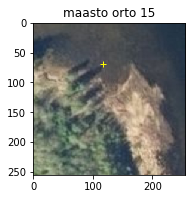

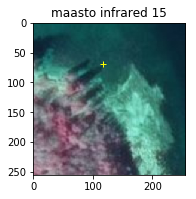

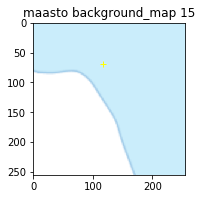

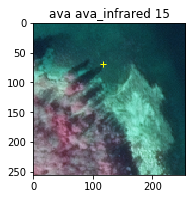

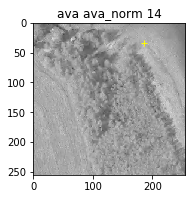

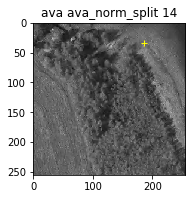

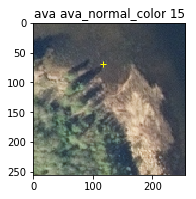

In [12]:
list_of_images_and_points = get_image_and_plot(fetcher.get_coordinates_from_file()[1], configuration)


In [13]:
data_source = fetcher.get_data_sources()[0]
df = fetcher.open_xyz_file_as_panda(data_source['name'])
sample = df.head(1000)
data_points = list()
for index, row in sample.iterrows():
    point_dict = transformer.create_info_object_from_panda_row(row, data_source['coordinate_system'], 15)
    images_and_info = get_image_and_plot(point_dict, configuration, show=False)
    data_points.append(images_and_info)
print('done')


done


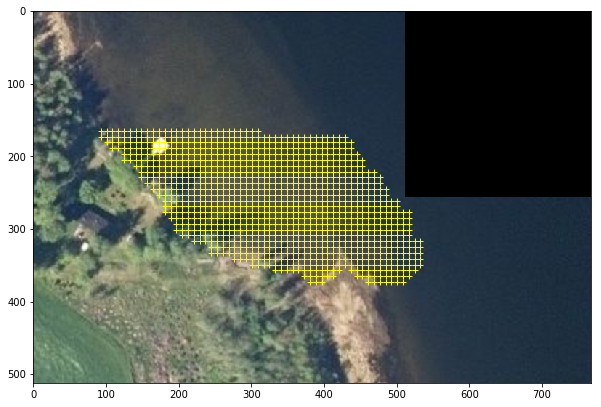

In [14]:
import matplotlib.pyplot as plt

images = configuration.web_maps[1].map_layers[0].image_tiles
def compare(normal):
    return normal.level, normal.row, normal.column
sorted_images = sorted(images, key=compare)
widths = len(set(i.column for i in sorted_images))
heights = len(set(i.row for i in sorted_images))
new_im = Image.new('RGB', (widths * 256, heights * 256))

x_offset = 0
y_offset = 0
previous_im = None
fig = plt.figure(figsize=(10, 10))
for im in sorted_images:

    if previous_im != None and previous_im.column != im.column:
        x_offset += im.image.size[0]
    if previous_im != None and previous_im.row != im.row:
        y_offset += im.image.size[1]
        x_offset = 0
    new_im.paste(im.image, (x_offset, y_offset))
    previous_im = im
    for point_ in data_points:
        image_tile = point_.image_points[0].image_tile
        if im.level == image_tile.level and im.row == image_tile.row and im.column == image_tile.column:
            image_location = point_.image_points[-1].data_point_in_image
            plt.plot(image_location.width + x_offset, image_location.height + y_offset, color='yellow', marker='+')

plt.imshow(new_im)
plt.show()
